In [1]:
import pandas as pd
import numpy as np

import re
import string

from pipeline import NLPProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag


import matplotlib.pyplot as plt
import plotly.graph_objects as go

from itertools import combinations
import itertools

import pickle


In [121]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [123]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

### Load in data 

#### Primarily text data that was scraped from boardgamegeek.com (code in bgg_scrape_25May notebook)

In [2]:
df_reviews = pd.read_csv('top_950_14May.csv')

In [82]:
df_reviews.head()

id                                           game  \
0  174430                                     Gloomhaven   
1  161936                      Pandemic Legacy: Season 1   
2  167791                              Terraforming Mars   
3  224517                              Brass: Birmingham   
4  182028  Through the Ages: A New Story of Civilization   

                                                 url  \
0  https://boardgamegeek.com/boardgame/174430/glo...   
1  https://boardgamegeek.com/boardgame/161936/pan...   
2  https://boardgamegeek.com/boardgame/167791/ter...   
3  https://boardgamegeek.com/boardgame/224517/bra...   
4  https://boardgamegeek.com/boardgame/182028/thr...   

                                         description  \
0  Gloomhaven  is a game of Euro-inspired tactica...   
1  Pandemic Legacy is a co-operative campaign gam...   
2  In the 2400s, mankind begins to terraform the ...   
3  Brass: Birmingham is an economic strategy game...   
4  Through the Ages: A New Story of Civilization ...   

                                             reviews  
0  [' Overall SummaryGloomhaven is truly an amazi...  
1  [' Pandemic: Legacy - Write Your Own Legacy in...  
2  [' 1. There\'s only one thing I don\'t like ab...  
3  [' IntroductionI love the original Brass game....  
4  ['  is the 2015 reimplementation of the popula...

In [83]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 5 columns):
id             950 non-null int64
game           950 non-null object
url            950 non-null object
description    950 non-null object
reviews        950 non-null object
dtypes: int64(1), object(4)
memory usage: 37.2+ KB


In [9]:
df_reviews['all_text'] = df_reviews['description']+df_reviews['reviews']

In [114]:
df_reviews['all_text'][0]

'Gloomhaven  is a game of Euro-inspired tactical combat in a persistent world of shifting motives. Players will take on the role of a wandering adventurer with their own special set of skills and their own reasons for traveling to this dark corner of the world. Players must work together out of necessity to clear out menacing dungeons and forgotten ruins. In the process, they will enhance their abilities with experience and loot, discover new locations to explore and plunder, and expand an ever-branching story fueled by the decisions they make.\n\nThis is a game with a persistent and changing world that is ideally played over many game sessions. After a scenario, players will make decisions on what to do, which will determine how the story continues, kind of like a &ldquo;Choose Your Own Adventure&rdquo; book. Playing through a scenario is a cooperative affair where players will fight against automated monsters using an innovative card system to determine the order of play and what a p

In [106]:
df_reviews['description'][0]

'Gloomhaven  is a game of Euro-inspired tactical combat in a persistent world of shifting motives. Players will take on the role of a wandering adventurer with their own special set of skills and their own reasons for traveling to this dark corner of the world. Players must work together out of necessity to clear out menacing dungeons and forgotten ruins. In the process, they will enhance their abilities with experience and loot, discover new locations to explore and plunder, and expand an ever-branching story fueled by the decisions they make.\n\nThis is a game with a persistent and changing world that is ideally played over many game sessions. After a scenario, players will make decisions on what to do, which will determine how the story continues, kind of like a &ldquo;Choose Your Own Adventure&rdquo; book. Playing through a scenario is a cooperative affair where players will fight against automated monsters using an innovative card system to determine the order of play and what a p

In [3]:
df_reviews.drop_duplicates(inplace=True)

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 0 to 949
Data columns (total 6 columns):
id             950 non-null int64
game           950 non-null object
url            950 non-null object
description    950 non-null object
reviews        950 non-null object
all_text       950 non-null object
dtypes: int64(1), object(5)
memory usage: 52.0+ KB


#### Load in BGG metadata

In [13]:
# Originally gave an encoding error
# Saved with encoding utf-8 using Sublime
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

df_bgg = pd.read_csv('bggtool_top_1000_edit.csv')

In [14]:
df_bgg.head()

id                                           name         designer  \
0  174430                                     Gloomhaven   Isaac Childres   
1  161936                      Pandemic Legacy: Season 1       Rob Daviau   
2  167791                              Terraforming Mars  Jacob Fryxelius   
3  224517                              Brass: Birmingham      Gavan Brown   
4  182028  Through the Ages: A New Story of Civilization   Vlaada Chvátil   

             publisher            artist  yearpublished  minplayers  \
0    Cephalofair Games  Alexandr Elichev           2017           1   
1    Z-Man Games, Inc.   Chris Quilliams           2015           2   
2            FryxGames   Isaac Fryxelius           2016           1   
3               Roxley     Lina Cossette           2018           2   
4  Czech Games Edition      Filip Murmak           2015           2   

   maxplayers  playingtime  minplaytime  ...  rank  averageweight  \
0           4          120           60  ...     1           3.82   
1           4           60           60  ...     2           2.83   
2           5          120          120  ...     3           3.24   
3           4          120           60  ...     4           3.93   
4           4          120          120  ...     5           4.40   

                                               image  \
0  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
1  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
2  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
3  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
4  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   

                                            category  \
0  Adventure, Exploration, Fantasy, Fighting, Min...   
1                             Environmental, Medical   
2  Economic, Environmental, Industry / Manufactur...   
3  Economic, Industry / Manufacturing, Transporta...   
4                  Card Game, Civilization, Economic   

                                            mechanic 1player  \
0  Action Retrieval, Campaign / Battle Card Drive...       R   
1  Action Points, Cooperative Game, Hand Manageme...       N   
2  Card Drafting, End Game Bonuses, Hand Manageme...       R   
3  Connections, Hand Management, Income, Loans, M...       N   
4  Action Points, Auction/Bidding, Auction: Dutch...       N   

                                         description  \
0  Gloomhaven  is a game of Euro-inspired tactica...   
1  Pandemic Legacy is a co-operative campaign gam...   
2  In the 2400s, mankind begins to terraform the ...   
3  Brass: Birmingham is an economic strategy game...   
4  Through the Ages: A New Story of Civilization ...   

                           domain  \
0  Strategy Games, Thematic Games   
1  Strategy Games, Thematic Games   
2                  Strategy Games   
3                  Strategy Games   
4                  Strategy Games   

                                              family age_poll  
0  Campaign Games, Components: Miniatures, Crowdf...    12.71  
1                   Campaign Games, Legacy, Pandemic    11.25  
2  Fryxgames' Future Timeline, Solitaire Games, S...    11.75  
3  Brass, Cities: Birmingham (England), Country: ...    13.30  
4                 Tableau Building, Through the Ages    13.99  

[5 rows x 23 columns]

In [17]:
df_bgg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
id               1000 non-null int64
name             1000 non-null object
designer         998 non-null object
publisher        1000 non-null object
artist           962 non-null object
yearpublished    1000 non-null int64
minplayers       1000 non-null int64
maxplayers       1000 non-null int64
playingtime      1000 non-null int64
minplaytime      1000 non-null int64
maxplaytime      1000 non-null int64
age              1000 non-null int64
average          1000 non-null float64
rank             1000 non-null int64
averageweight    1000 non-null float64
image            1000 non-null object
category         995 non-null object
mechanic         999 non-null object
1player          1000 non-null object
description      1000 non-null object
domain           997 non-null object
family           969 non-null object
age_poll         1000 non-null float64
dtypes: float64(3), int64(9), ob

In [107]:
df_bgg.columns

Index(['id', 'name', 'designer', 'publisher', 'artist', 'yearpublished',
       'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime',
       'age', 'average', 'rank', 'averageweight', 'image', 'category',
       'mechanic', '1player', 'description', 'domain', 'family', 'age_poll'],
      dtype='object')

In [109]:
df_bgg.drop('description', axis=1, inplace=True)

In [408]:
df_bgg.columns

Index(['id', 'name', 'designer', 'publisher', 'artist', 'yearpublished',
       'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime',
       'age', 'average', 'rank', 'averageweight', 'image', 'category',
       'mechanic', '1player', 'domain', 'family', 'age_poll'],
      dtype='object')

#### Combine text and metadata dataframes

In [111]:
df = pd.merge(df_bgg, df_reviews[['id', 'url', 'reviews', 'description']], on='id', how='left')

In [112]:
df.columns

Index(['id', 'name', 'designer', 'publisher', 'artist', 'yearpublished',
       'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime',
       'age', 'average', 'rank', 'averageweight', 'image', 'category',
       'mechanic', '1player', 'domain', 'family', 'age_poll', 'url', 'reviews',
       'description'],
      dtype='object')

In [24]:
df.head()

id                                           name         designer  \
0  174430                                     Gloomhaven   Isaac Childres   
1  161936                      Pandemic Legacy: Season 1       Rob Daviau   
2  167791                              Terraforming Mars  Jacob Fryxelius   
3  224517                              Brass: Birmingham      Gavan Brown   
4  182028  Through the Ages: A New Story of Civilization   Vlaada Chvátil   

             publisher            artist  yearpublished  minplayers  \
0    Cephalofair Games  Alexandr Elichev           2017           1   
1    Z-Man Games, Inc.   Chris Quilliams           2015           2   
2            FryxGames   Isaac Fryxelius           2016           1   
3               Roxley     Lina Cossette           2018           2   
4  Czech Games Edition      Filip Murmak           2015           2   

   maxplayers  playingtime  minplaytime  ...  \
0           4          120           60  ...   
1           4           60           60  ...   
2           5          120          120  ...   
3           4          120           60  ...   
4           4          120          120  ...   

                                               image  \
0  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
1  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
2  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
3  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   
4  E:\Users\user\Documents\GitHub\Metis\bgg1toolu...   

                                            category  \
0  Adventure, Exploration, Fantasy, Fighting, Min...   
1                             Environmental, Medical   
2  Economic, Environmental, Industry / Manufactur...   
3  Economic, Industry / Manufacturing, Transporta...   
4                  Card Game, Civilization, Economic   

                                            mechanic  1player  \
0  Action Retrieval, Campaign / Battle Card Drive...        R   
1  Action Points, Cooperative Game, Hand Manageme...        N   
2  Card Drafting, End Game Bonuses, Hand Manageme...        R   
3  Connections, Hand Management, Income, Loans, M...        N   
4  Action Points, Auction/Bidding, Auction: Dutch...        N   

                                         description  \
0  Gloomhaven  is a game of Euro-inspired tactica...   
1  Pandemic Legacy is a co-operative campaign gam...   
2  In the 2400s, mankind begins to terraform the ...   
3  Brass: Birmingham is an economic strategy game...   
4  Through the Ages: A New Story of Civilization ...   

                           domain  \
0  Strategy Games, Thematic Games   
1  Strategy Games, Thematic Games   
2                  Strategy Games   
3                  Strategy Games   
4                  Strategy Games   

                                              family age_poll  \
0  Campaign Games, Components: Miniatures, Crowdf...    12.71   
1                   Campaign Games, Legacy, Pandemic    11.25   
2  Fryxgames' Future Timeline, Solitaire Games, S...    11.75   
3  Brass, Cities: Birmingham (England), Country: ...    13.30   
4                 Tableau Building, Through the Ages    13.99   

                                                 url  \
0  https://boardgamegeek.com/boardgame/174430/glo...   
1  https://boardgamegeek.com/boardgame/161936/pan...   
2  https://boardgamegeek.com/boardgame/167791/ter...   
3  https://boardgamegeek.com/boardgame/224517/bra...   
4  https://boardgamegeek.com/boardgame/182028/thr...   

                                             reviews  
0  [' Overall SummaryGloomhaven is truly an amazi...  
1  [' Pandemic: Legacy - Write Your Own Legacy in...  
2  [' 1. There\'s only one thing I don\'t like ab...  
3  [' IntroductionI love the original Brass game....  
4  ['  is the 2015 reimplementation of the popula...  

[5 rows x 25 columns]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 25 columns):
id               1000 non-null int64
name             1000 non-null object
designer         998 non-null object
publisher        1000 non-null object
artist           962 non-null object
yearpublished    1000 non-null int64
minplayers       1000 non-null int64
maxplayers       1000 non-null int64
playingtime      1000 non-null int64
minplaytime      1000 non-null int64
maxplaytime      1000 non-null int64
age              1000 non-null int64
average          1000 non-null float64
rank             1000 non-null int64
averageweight    1000 non-null float64
image            1000 non-null object
category         995 non-null object
mechanic         999 non-null object
1player          1000 non-null object
description      1000 non-null object
domain           997 non-null object
family           969 non-null object
age_poll         1000 non-null float64
url              950 non-null ob

In [45]:
df = df.drop_duplicates()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 0 to 999
Data columns (total 25 columns):
id               996 non-null int64
name             996 non-null object
designer         994 non-null object
publisher        996 non-null object
artist           958 non-null object
yearpublished    996 non-null int64
minplayers       996 non-null int64
maxplayers       996 non-null int64
playingtime      996 non-null int64
minplaytime      996 non-null int64
maxplaytime      996 non-null int64
age              996 non-null int64
average          996 non-null float64
rank             996 non-null int64
averageweight    996 non-null float64
image            996 non-null object
category         991 non-null object
mechanic         995 non-null object
1player          996 non-null object
description      996 non-null object
domain           993 non-null object
family           965 non-null object
age_poll         996 non-null float64
url              947 non-null object
reviews      

In [47]:
df.to_csv('bgg_join_950.csv', index=False)

In [55]:
df.columns

Index(['id', 'name', 'designer', 'publisher', 'artist', 'yearpublished',
       'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime',
       'age', 'average', 'rank', 'averageweight', 'image', 'category',
       'mechanic', '1player', 'description', 'domain', 'family', 'age_poll',
       'url', 'reviews'],
      dtype='object')

#### I had some missing data from the full 1000 scrape of games I attempted. 
#### I ended up just using the 950 rows that I had

In [39]:
df[df['category'].isnull()][['id','name', 'url']]

id                            name  \
663  106217                          Hawaii   
693  160851  Lanterns: The Harvest Festival   
732  234671           Pandemic: Rising Tide   
926  264055                    Draftosaurus   
990  165986                          Royals   

                                                   url  
663  https://boardgamegeek.com/boardgame/106217/hawaii  
693  https://boardgamegeek.com/boardgame/160851/lan...  
732  https://boardgamegeek.com/boardgame/234671/pan...  
926  https://boardgamegeek.com/boardgame/264055/dra...  
990  https://boardgamegeek.com/boardgame/165986/royals

In [48]:
df[df['designer'].isnull()][['id','name', 'url']]

id                         name  \
734  165838  Space Hulk (Fourth Edition)   
886  204836        Escape Room: The Game   

                                                   url  
734  https://boardgamegeek.com/boardgame/165838/spa...  
886  https://boardgamegeek.com/boardgame/204836/esc...

In [49]:
df[df['artist'].isnull()][['id','name', 'url']]

id                                               name  \
77   285774                    Marvel Champions: The Card Game   
94   175155                                    Forbidden Stars   
102  146652  Legendary Encounters: An Alien Deck Building Game   
105  269385    The Lord of the Rings: Journeys in Middle-earth   
337  257501                      KeyForge: Call of the Archons   
366   36553                           Time's Up! Title Recall!   
383  183562  Star Wars: X-Wing Miniatures Game - The Force ...   
418  169255  A Game of Thrones: The Card Game (Second Edition)   
478  230253                             Star Realms: Frontiers   
492  181521           Warhammer Quest: The Adventure Card Game   
533  168584                                Love Letter: Batman   
536   79127                          Star Trek: Fleet Captains   
537  179803                             Arcadia Quest: Inferno   
577  169654                                 Deep Sea Adventure   
587  224597                  Warhammer Underworlds: Shadespire   
589  148575            Marvel Dice Masters: Avengers vs. X-Men   
619    2398                                           Cribbage   
620  163602                               XCOM: The Board Game   
640    2181                                             Bridge   
645   27976           Heroscape Master Set: Swarm of the Marro   
683  256382                                  Disney Villainous   
686  158275                 Marvel Dice Masters: Uncanny X-Men   
704  174570  Legendary Encounters: A Predator Deck Building...   
717  168917                   Smash Up: Pretty Pretty Smash Up   
734  165838                        Space Hulk (Fourth Edition)   
747  182340                               Star Trek: Frontiers   
754  125678                       DC Comics Deck-Building Game   
758   25669                                            Qwirkle   
810  184151            Legend of the Five Rings: The Card Game   
849  151007  Pathfinder Adventure Card Game: Skull & Shackl...   
851     327                                      Loopin' Louie   
901     681                                             Quarto   
923  123955                          Thunderbolt Apache Leader   
928   30618                                   Eat Poop You Cat   
929  177802                         Smash Up: It's Your Fault!   
943   16395                                         Blokus Duo   
950   23540                  1889: History of Shikoku Railways   
988  159109                               XenoShyft: Onslaught   

                                                   url  
77   https://boardgamegeek.com/boardgame/285774/mar...  
94   https://boardgamegeek.com/boardgame/175155/for...  
102  https://boardgamegeek.com/boardgame/146652/leg...  
105  https://boardgamegeek.com/boardgame/269385/lor...  
337  https://boardgamegeek.com/boardgame/257501/key...  
366  https://boardgamegeek.com/boardgame/36553/time...  
383  https://boardgamegeek.com/boardgame/183562/sta...  
418  https://boardgamegeek.com/boardgame/169255/gam...  
478  https://boardgamegeek.com/boardgame/230253/sta...  
492  https://boardgamegeek.com/boardgame/181521/war...  
533  https://boardgamegeek.com/boardgame/168584/lov...  
536  https://boardgamegeek.com/boardgame/79127/star...  
537  https://boardgamegeek.com/boardgame/179803/arc...  
577  https://boardgamegeek.com/boardgame/169654/dee...  
587  https://boardgamegeek.com/boardgame/224597/war...  
589  https://boardgamegeek.com/boardgame/148575/mar...  
619                                                NaN  
620  https://boardgamegeek.com/boardgame/163602/xco...  
640    https://boardgamegeek.com/boardgame/2181/bridge  
645  https://boardgamegeek.com/boardgame/27976/hero...  
683  https://boardgamegeek.com/boardgame/256382/dis...  
686  https://boardgamegeek.com/boardgame/158275/mar...  
704  https://boardgamegeek.com/boardgame/174570/leg...  
717  https://boardgamegeek.com/boardgame/168917/sma...  
734  http

### Pre-processing text data

In [5]:
#nltk.download('words')
words = set(nltk.corpus.words.words())

#### Removing some words after seeing their frequency and deciding they weren't adding to the model

In [6]:
my_stopwords = ['quot', 'game', 'play', 'player', 'like', 'good']

for item in my_stopwords:
    words.remove(item)

In [7]:
def preprocess_text(my_text):
    """
    Take in column (pandas series) of text and return 'cleaned' text
    
    Input: column of text
    Output: column of cleaned text
    """
    new_text = []
    
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    alpha_lower = my_text.map(alphanumeric).map(punc_lower)
    
    for item in alpha_lower:
        new_text.append(" ".join(w for w in nltk.wordpunct_tokenize(item) if w.lower() in words or not w.isalpha()))
        
    return new_text
    

In [11]:
blah_corpus = preprocess_text(df_reviews['all_text'])

#### Use nouns and adjectives only to see if that makes a difference

In [8]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [12]:
### This took about 5 minutes to run
noun_corpus = [nouns_adj(item) for item in blah_corpus]

In [155]:
# with open('noun_adj_corpus_19May.pickle', 'wb') as f:
#     pickle.dump(noun_corpus, f)

In [166]:
# with open('noun_adj_corpus_1830_19May.pickle', 'wb') as f:
#     pickle.dump(noun_corpus, f)

#### I need a better process of coming up with names for testing various models

In [128]:
nlp_blah = NLPProcessor(vectorizer=TfidfVectorizer(),
                   tokenizer=TreebankWordTokenizer().tokenize)
nlp_blah.fit(blah_corpus)

In [129]:
sparse_word_blah = nlp_blah.transform(blah_corpus)

In [135]:
feature_names_blah = nlp_blah.vectorizer.get_feature_names()

In [156]:
nlp_noun = NLPProcessor(vectorizer=TfidfVectorizer(),
                   tokenizer=TreebankWordTokenizer().tokenize)
nlp_noun.fit(noun_corpus)

In [157]:
type(nlp_noun)

pipeline.NLPProcessor

In [13]:
def do_nlp(my_corpus, ng_range=(1,1), max_df=1.0, min_df=1):
    """
    This function takes a corpus of words (in this case processed with 'preprocess_text' function)
    and returns transform of NLPProcessor function, sparse_word, and feature_names
    
    """
    
    nlp = NLPProcessor(vectorizer=TfidfVectorizer(ngram_range=ng_range, max_df=1.0, min_df=1),
                   tokenizer=TreebankWordTokenizer().tokenize)
    nlp.fit(my_corpus)
    
    sparse_word = nlp.transform(my_corpus)
    
    feature_names = nlp.vectorizer.get_feature_names()
    
    return nlp, sparse_word, feature_names
    

In [14]:
nlp1, sparse_w1, feat_names1 = do_nlp(noun_corpus, (1,3))

In [16]:
def plot_word_freq(sparse_word, feature_names):
    
    """
    This function takes in sparse_word and feature_names from the 'do_nlp' function and 
    uses plotly to display the top 50 word frequencies and bottom 100 word frequencies
    
    """
    count_vec = np.asarray(sparse_word.sum(axis=0)).ravel()
    zipped = list(zip(feature_names, count_vec))
    x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
    # Now I want to extract out on the top 15 and bottom 15 words
    Y = np.concatenate([y[0:15], y[-16:-1]])
    X = np.concatenate([x[0:15], x[-16:-1]])

    # Plotting the Plot.ly plot for the Top 50 word frequencies
    data = [go.Bar(
                x = x[0:50],
                y = y[0:50],
                marker= dict(colorscale='Jet',
                             color = y[0:50]
                            ),
                text='Word counts'
        )]

    layout = go.Layout(
        title='Top 50 Word frequencies after Preprocessing'
    )

    fig = go.Figure(data=data, layout=layout)

    fig.show()

    # Plotting the Plot.ly plot for the Top 50 word frequencies
    data = [go.Bar(
                x = x[-100:],
                y = y[-100:],
                marker= dict(colorscale='Portland',
                             color = y[-100:]
                            ),
                text='Word counts'
        )]

    layout = go.Layout(
        title='Bottom 100 Word frequencies after Preprocessing'
    )

    fig = go.Figure(data=data, layout=layout)

    fig.show()
    

#### Based on the plot below, I debated removing 'board' and 'card' from the word list, but I decided to keep them in because they are descriptors that differentiate between 'board games' and 'card games'. Not sure if this was the right choice. I'd need to run even more comparisons I suppose to make some sort of determination. 

In [17]:
plot_word_freq(sparse_w1, feat_names1)

In [249]:
# process_df_blah = pd.DataFrame(sparse_word_blah.toarray(), columns=feature_names_blah)
# process_df_blah.head()

In [20]:
# process_df.to_csv('process_df_15May.csv', index=False)

In [75]:
# Takes too long and too much space
# process_df2.to_csv('process_df2_17May.csv', index=False)

### Runing and comparing models

In [144]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Displays the top n terms in each topic
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [237]:
def run_model(model, n_topics, sparse, feature_names):
    """
    This function takes output from 'do_nlp' function, and one additional input, n_topics, 
    and outputs the model with number of topics specified by n_topics, doc_topic matrix, and doc_topic_df dataframe
    It also runs 'display_topics' function to display the top 5 words for each topic.
    """
    model_type = model(n_topics)
    doc_topic = model_type.fit_transform(sparse)
    
    doc_topic_df = pd.DataFrame(doc_topic.round(5),
             columns = ["component_"+str(i+1) for i in range(doc_topic.shape[1])])
    
    display_topics(model_type, feature_names, 5)
    
    return model_type, doc_topic, doc_topic_df
    

#### Initially, I was comparing models based on the topics that were generated


In [250]:
my_model1, my_doc_topic, my_doc_topic_df = run_model(TruncatedSVD, 10, sparse_w1, feat_names1)


Topic  1
card, board, time, dice, turn

Topic  2
dice, unit, combat, hero, scenario

Topic  3
dice, die, roll, tile, dice dice

Topic  4
unit, war, combat, battle, infantry

Topic  5
tile, dungeon, hero, monster, character

Topic  6
tile, unit, card, image courtesy, castle

Topic  7
jack, detective, clue, team, inspector

Topic  8
ship, tile, star, island, deck

Topic  9
jack, dungeon, unit, thunderstone, worker

Topic  10
jack, faction, city, tile, building


In [281]:
my_model_15, my_doc_topic_15, my_doc_topic_df_15 = run_model(TruncatedSVD, 15, sparse_w1, feat_names1)


Topic  1
card, board, time, dice, turn

Topic  2
dice, unit, combat, hero, scenario

Topic  3
dice, die, roll, tile, dice dice

Topic  4
unit, war, combat, battle, army

Topic  5
tile, dungeon, hero, monster, character

Topic  6
tile, card, unit, image courtesy, castle

Topic  7
jack, detective, clue, team, inspector

Topic  8
ship, tile, star, planet, mission

Topic  9
city, pandemic, faction, legacy, influence

Topic  10
jack, detective, inspector, tile, ship

Topic  11
faction, worker, smash, worker placement, power

Topic  12
faction, company, auction, railroad, train

Topic  13
pandemic, legacy, deck, worker, aeon

Topic  14
car, board, action, region, race

Topic  15
thunderstone, werewolf, castle, dominion, dungeon


In [282]:
blah_model_15, blah_doc_topic_15, blah_doc_topic_df_15 = run_model(TruncatedSVD, 15, sparse_word_blah, feature_names_blah)


Topic  1
card, like, board, time, dice

Topic  2
dice, combat, unit, hero, scenario

Topic  3
dice, roll, die, tile, ship

Topic  4
unit, war, combat, battle, army

Topic  5
tile, dungeon, hero, monster, quest

Topic  6
ship, goods, worker, action, planet

Topic  7
clue, team, jack, detective, deduction

Topic  8
ship, tile, star, island, crew

Topic  9
faction, smash, minion, power, bases

Topic  10
auction, bid, faction, bidding, money

Topic  11
city, ship, pandemic, tile, civilization

Topic  12
building, deck, train, railroad, squad

Topic  13
car, train, board, track, railroad

Topic  14
dungeon, thunderstone, civilization, dominion, monster

Topic  15
jack, castle, detective, star, ripper


In [198]:
display_topics(lsa_blah_ten, feature_names_blah, 5)


Topic  1
card, like, board, time, dice

Topic  2
dice, combat, unit, hero, scenario

Topic  3
dice, roll, die, tile, ship

Topic  4
unit, war, combat, battle, army

Topic  5
tile, dungeon, hero, monster, quest

Topic  6
ship, goods, worker, action, planet

Topic  7
dungeon, building, hero, thunderstone, monster

Topic  8
ship, tile, star, goods, planet

Topic  9
faction, smash, minion, star, bases

Topic  10
auction, bid, faction, company, bidding


#### I moved on to comparing the games that were similar based on the output of the two functions below

In [767]:
def game_to_games(game_index, doc_topic, n_games):
    """
    Given a game index (from the dataframe), print the top n games by cosine distance
    
    Input: 
            game_index, int, is index of row associated with game
            doc_topic, numpy array, is array with games as rows, topic contribution as columns
            n_games, int, is number of games to return that are most similar
    
    """
    my_array = pairwise_distances(doc_topic[game_index].reshape(1, -1),doc_topic,metric='cosine').argsort()[0][:n_games+1]
#     print(df_reviews[['game', 'description']].iloc[my_array])
    print(df_reviews['game'].iloc[my_array])
    

In [270]:
def top_5_similar_2(list_string, my_nlp, model_type, doc_topic):
    """
    Given a list containing a string, print the top 5 games based on cosine distance 
    """
    vec = my_nlp.transform(list_string)
    vtrans = model_type.transform(vec)
    array_5 = pairwise_distances(vtrans, doc_topic, metric='cosine').argsort()[0][0:5]
    print(df_reviews[['game', 'description']].iloc[array_5])

In [252]:
game_to_games(0, my_doc_topic, 5)

                          game  \
0                   Gloomhaven   
31      Kingdom Death: Monster   
314            Sword & Sorcery   
512     Arcadia Quest: Inferno   
353           Legends of Andor   
410  Runebound (Third Edition)   

                                           description  
0    Gloomhaven  is a game of Euro-inspired tactica...  
31   Kingdom Death: Monster is a fully cooperative ...  
314  Description from the publisher:\n\nSword &amp;...  
512  Inferno is a standalone expansion to Arcadia Q...  
353  Game description from the publisher:\n\nLegend...  
410  Description from the publisher:\n\nWelcome to ...  


In [780]:
game_to_games(728, my_doc_topic, 5)

728         Meeple Circus
940                Ubongo
816    Animal Upon Animal
923        Forum Trajanum
775               ICECOOL
880          Draftosaurus
Name: game, dtype: object


In [781]:
game_to_games(728, doc_topic_ten, 5)

728                    Meeple Circus
241                         Takenoko
686                          Mahjong
280    Azul: Stained Glass of Sintra
923                   Forum Trajanum
725                   Cottage Garden
Name: game, dtype: object


In [782]:
game_to_games(728, my_doc_topic_15, 5)

728       Meeple Circus
880        Draftosaurus
940              Ubongo
838         Blue Lagoon
775             ICECOOL
349    The Isle of Cats
Name: game, dtype: object


In [783]:
game_to_games(728, blah_doc_topic_15, 5)

728                    Meeple Circus
280    Azul: Stained Glass of Sintra
675                       Zooloretto
293            Azul: Summer Pavilion
241                         Takenoko
725                   Cottage Garden
Name: game, dtype: object


In [321]:
my_list_s = ["tile laying games are fun"]

In [403]:
top_5_similar_2(my_list_s, nlp1, my_model1, my_doc_topic)

                                               game  \
898                                 Dungeon Fighter   
327                   Descent: Journeys in the Dark   
544                                       HeroQuest   
631            Last Night on Earth: The Zombie Game   
93   Descent: Journeys in the Dark (Second Edition)   

                                           description  
898  Explore spooky dungeons, find glorious treasur...  
327  Descent: Journeys in the Dark is a semi-cooper...  
544  HeroQuest is Milton Bradley's approach to a Du...  
631  Last Night on Earth: The Zombie Game is a surv...  
93   In Descent: Journeys in the Dark (Second Editi...  


In [404]:
top_5_similar_2(my_list_s, nlp1, my_model_15, my_doc_topic_15)

                          game  \
476                  Formula D   
344                   PitchCar   
855                  Catacombs   
674  Catacombs (Third Edition)   
638              Thunder Alley   

                                           description  
476  Formula D is a high stakes Formula One type ra...  
344  This game entry refers to two nearly identical...  
855  If you were directed here from the Catacombs T...  
674  Catacombs is an award-winning, cooperative boa...  
638  Thunder Alley is a stock car racing game for 2...  


In [405]:
top_5_similar_2(my_list_s, nlp_blah, lsa_blah_ten, doc_topic_ten)

                                     game  \
730                           Loony Quest   
898                       Dungeon Fighter   
928                  Legacy of Dragonholt   
674             Catacombs (Third Edition)   
631  Last Night on Earth: The Zombie Game   

                                           description  
730  In the wonderful land of Arkadia, a very old k...  
898  Explore spooky dungeons, find glorious treasur...  
928  Gather your band of heroes and journey to Real...  
674  Catacombs is an award-winning, cooperative boa...  
631  Last Night on Earth: The Zombie Game is a surv...  


In [406]:
top_5_similar_2(my_list_s, nlp_blah, blah_model_15, blah_doc_topic_15)

                          game  \
898            Dungeon Fighter   
674  Catacombs (Third Edition)   
891            Dungeon Twister   
772   Level 7 [Omega Protocol]   
777            Warhammer Quest   

                                           description  
898  Explore spooky dungeons, find glorious treasur...  
674  Catacombs is an award-winning, cooperative boa...  
891  Dungeon Twister is a 2-player high level strat...  
772  Game description from the publisher:\n\nLEVEL ...  
777  Warhammer Quest is the original game in the Wa...  


nlp_blah, sparse_word_blah, feature_names_blah
nlp1, sparse_w1, feat_names1 

blah_model_15, blah_doc_topic_15, blah_doc_topic_df_15 = run_model(TruncatedSVD, 15, sparse_word_blah, feature_names_blah)
my_model_15, my_doc_topic_15, my_doc_topic_df_15 = run_model(TruncatedSVD, 15, sparse_w1, feat_names1)

In [327]:
nmf_model_15, doc_topic_nmf_15, doc_topic_nmf_df_15 = run_model(NMF, 15, sparse_w1, feat_names1)


Topic  1
card, hand, deck, round, suit

Topic  2
deck, card, dominion, ascension, deck building

Topic  3
dice, die, roll, dice dice, casino

Topic  4
unit, infantry, combat, squad, battle

Topic  5
hero, character, scenario, adventure, story

Topic  6
tile, board, castle, island, temple

Topic  7
jack, detective, inspector, ripper, jack ripper

Topic  8
ship, goods, planet, crew, space

Topic  9
worker, action, board, building, worker placement

Topic  10
city, pandemic, legacy, disease, civilization

Topic  11
faction, war, battle, political, military

Topic  12
car, train, company, railroad, stock

Topic  13
auction, bid, bidding, money, phase

Topic  14
team, werewolf, clue, party, time

Topic  15
dungeon, thunderstone, monster, village, hero


In [792]:
nlp1

In [794]:
with open('df_reviews_21May.pickle', 'wb') as f:
    pickle.dump(df_reviews, f)

In [793]:
with open('nlp1_15_21May.pickle', 'wb') as f:
    pickle.dump(nlp1, f)

In [775]:
with open('nmf_model_15_21May.pickle', 'wb') as f:
    pickle.dump(nmf_model_15, f)

In [776]:
with open('doc_topic_nmf_15_21May.pickle', 'wb') as f:
    pickle.dump(doc_topic_nmf_15, f)

In [777]:
with open('doc_topic_nmf_df_15_21May.pickle', 'wb') as f:
    pickle.dump(doc_topic_nmf_df_15, f)

In [778]:
with open('sparse_w1_21May.pickle', 'wb') as f:
    pickle.dump(sparse_w1, f)

In [779]:
with open('feat_names1_21May.pickle', 'wb') as f:
    pickle.dump(feat_names1, f)

In [326]:
blah_nmf_model_15, blah_doc_topic_nmf_15, blah_doc_topic_nmf_df_15 = run_model(NMF, 15, sparse_word_blah, feature_names_blah)


Topic  1
card, hand, round, deck, scoring

Topic  2
ship, goods, crew, planet, pirate

Topic  3
dice, roll, die, rolling, rolled

Topic  4
unit, war, combat, battle, army

Topic  5
hero, dungeon, character, monster, quest

Topic  6
tile, scoring, castle, board, score

Topic  7
like, team, clue, time, board

Topic  8
worker, action, building, board, like

Topic  9
faction, smash, minion, power, bases

Topic  10
auction, bid, bidding, money, phase

Topic  11
city, civilization, military, building, pandemic

Topic  12
train, railroad, company, ticket, stock

Topic  13
car, racing, race, track, factory

Topic  14
deck, dominion, card, ascension, building

Topic  15
jack, detective, ripper, sherlock, inspector


In [773]:
game_to_games(728, blah_doc_topic_nmf_15, 5)

728                     Meeple Circus
725                    Cottage Garden
894                            Menara
249    Survive: Escape from Atlantis!
655                  Forbidden Island
280     Azul: Stained Glass of Sintra
Name: game, dtype: object


In [795]:
my_list_s = ["Let's play a war game!"]

In [796]:
top_5_similar_2(my_list_s, nlp1, nmf_model_15, doc_topic_nmf_15)

                                                  game  \
531                                   Washington's War   
788                                 Battle for Rokugan   
818                                     For the People   
441  Triumph & Tragedy: European Balance of Power 1...   
289                                              Maria   

                                           description  
531  (from GMT's website:)\n\nWashington&rsquo;s Wa...  
788  Conquer the realm and bring honor to your clan...  
818  (from GMT website:)\n\nFor the People is a gra...  
441  Triumph &amp; Tragedy is a geopolitical strate...  
289  MARIA is a game based on the War of the Austri...  


In [790]:
top_5_similar_2(my_list_s, nlp_blah, blah_nmf_model_15, blah_doc_topic_nmf_15)

              game                                        description
677     Snow Tails  Snow Tails is set in the snowy world of the Ar...
344       PitchCar  This game entry refers to two nearly identical...
476      Formula D  Formula D is a high stakes Formula One type ra...
485    Specter Ops  A secret agent of A.R.K. has infiltrated a top...
638  Thunder Alley  Thunder Alley is a stock car racing game for 2...


In [791]:
i = 1
game_to_games(i, doc_topic_nmf_15, 10)
print('\n')
game_to_games(i, blah_doc_topic_nmf_15, 10)
print('\n')
game_to_games(i, b_doc_top_domain, 10)

1                           Pandemic Legacy: Season 1
30                          Pandemic Legacy: Season 2
696                             Pandemic: Rising Tide
83                                   Pandemic: Iberia
82                                           Pandemic
334                        Pandemic: Reign of Cthulhu
371                            Pandemic: Fall of Rome
197          Clank! Legacy: Acquisitions Incorporated
636                                      Sprawlopolis
610    Maharaja: The Game of Palace Building in India
937                                       New Angeles
Name: game, dtype: object


1                 Pandemic Legacy: Season 1
30                Pandemic Legacy: Season 2
696                   Pandemic: Rising Tide
82                                 Pandemic
244                                Tapestry
937                             New Angeles
653    Sid Meier's Civilization: A New Dawn
905                       Mega Civilization
334              Pandemic:

### Adding metadata to the model
#### I added in metadata from BGG including 'domain' or broad categories of games.
#### These were 'dummified' and then concatenated to the topic matrix to try and improve my model. 

In [717]:
df_fac_dom.head()

id                                           name  minplayers  \
0  174430                                     Gloomhaven           1   
1  161936                      Pandemic Legacy: Season 1           2   
2  167791                              Terraforming Mars           1   
3  224517                              Brass: Birmingham           2   
4  182028  Through the Ages: A New Story of Civilization           2   

   maxplayers  averageweight  Abstract Games  Children's Games  \
0           4           3.82               0                 0   
1           4           2.83               0                 0   
2           5           3.24               0                 0   
3           4           3.93               0                 0   
4           4           4.40               0                 0   

   Customizable Games  Family_Games  Party_Games  Strategy_Games  \
0                   0             0            0               1   
1                   0             0            0               1   
2                   0             0            0               1   
3                   0             0            0               1   
4                   0             0            0               1   

   Thematic_Games  War_Games  
0               1          0  
1               1          0  
2               0          0  
3               0          0  
4               0          0

In [724]:
sub_df_fac_dom = df_fac_dom.loc[:,'averageweight':]

In [728]:
num_sub_df_fac_dom = sub_df_fac_dom.to_numpy()

In [729]:
num_sub_df_fac_dom.shape

(950, 9)

In [733]:
b_doc_top_domain = np.concatenate((blah_doc_topic_nmf_15, num_sub_df_fac_dom), axis=1)

In [734]:
b_doc_top_domain.shape

(950, 24)

In [735]:
with open('b_doc_top_domain_1500_20May.pickle', 'wb') as f:
    pickle.dump(b_doc_top_domain, f)

In [470]:
df_factors = df_subset[['id', 'name',  'minplayers', 'maxplayers', 
       'averageweight', 'category', 'mechanic', 'domain', 'family']]

In [631]:
df_factors.head()

id                                           name  minplayers  \
0  174430                                     Gloomhaven           1   
1  161936                      Pandemic Legacy: Season 1           2   
2  167791                              Terraforming Mars           1   
3  224517                              Brass: Birmingham           2   
4  182028  Through the Ages: A New Story of Civilization           2   

   maxplayers  averageweight  \
0           4           3.82   
1           4           2.83   
2           5           3.24   
3           4           3.93   
4           4           4.40   

                                            category  \
0  Adventure, Exploration, Fantasy, Fighting, Min...   
1                             Environmental, Medical   
2  Economic, Environmental, Industry / Manufactur...   
3  Economic, Industry / Manufacturing, Transporta...   
4                  Card Game, Civilization, Economic   

                                            mechanic  \
0  Action Retrieval, Campaign / Battle Card Drive...   
1  Action Points, Cooperative Game, Hand Manageme...   
2  Card Drafting, End Game Bonuses, Hand Manageme...   
3  Connections, Hand Management, Income, Loans, M...   
4  Action Points, Auction/Bidding, Auction: Dutch...   

                           domain  \
0  Strategy Games, Thematic Games   
1  Strategy Games, Thematic Games   
2                  Strategy Games   
3                  Strategy Games   
4                  Strategy Games   

                                              family  
0  Campaign Games, Components: Miniatures, Crowdf...  
1                   Campaign Games, Legacy, Pandemic  
2  Fryxgames' Future Timeline, Solitaire Games, S...  
3  Brass, Cities: Birmingham (England), Country: ...  
4                 Tableau Building, Through the Ages

In [696]:
df_factors_domains = pd.concat([df_factors, df_domains], axis=1)

In [697]:
df_factors_domains.head()

id                                           name  minplayers  \
0  174430                                     Gloomhaven           1   
1  161936                      Pandemic Legacy: Season 1           2   
2  167791                              Terraforming Mars           1   
3  224517                              Brass: Birmingham           2   
4  182028  Through the Ages: A New Story of Civilization           2   

   maxplayers  averageweight  \
0           4           3.82   
1           4           2.83   
2           5           3.24   
3           4           3.93   
4           4           4.40   

                                            category  \
0  Adventure, Exploration, Fantasy, Fighting, Min...   
1                             Environmental, Medical   
2  Economic, Environmental, Industry / Manufactur...   
3  Economic, Industry / Manufacturing, Transporta...   
4                  Card Game, Civilization, Economic   

                                            mechanic  \
0  Action Retrieval, Campaign / Battle Card Drive...   
1  Action Points, Cooperative Game, Hand Manageme...   
2  Card Drafting, End Game Bonuses, Hand Manageme...   
3  Connections, Hand Management, Income, Loans, M...   
4  Action Points, Auction/Bidding, Auction: Dutch...   

                           domain  \
0  Strategy Games, Thematic Games   
1  Strategy Games, Thematic Games   
2                  Strategy Games   
3                  Strategy Games   
4                  Strategy Games   

                                              family  Abstract Games  \
0  Campaign Games, Components: Miniatures, Crowdf...               0   
1                   Campaign Games, Legacy, Pandemic               0   
2  Fryxgames' Future Timeline, Solitaire Games, S...               0   
3  Brass, Cities: Birmingham (England), Country: ...               0   
4                 Tableau Building, Through the Ages               0   

   Children's Games  Customizable Games  Family_Games  Party_Games  \
0                 0                   0             0            0   
1                 0                   0             0            0   
2                 0                   0             0            0   
3                 0                   0             0            0   
4                 0                   0             0            0   

   Strategy_Games  Thematic_Games  War_Games  
0               1               1          0  
1               1               1          0  
2               1               0          0  
3               1               0          0  
4               1               0          0

In [698]:
df_fac_dom = df_factors_domains.drop(['category', 'mechanic', 'domain', 'family'], axis=1)

In [699]:
df_fac_dom.head()

id                                           name  minplayers  \
0  174430                                     Gloomhaven           1   
1  161936                      Pandemic Legacy: Season 1           2   
2  167791                              Terraforming Mars           1   
3  224517                              Brass: Birmingham           2   
4  182028  Through the Ages: A New Story of Civilization           2   

   maxplayers  averageweight  Abstract Games  Children's Games  \
0           4           3.82               0                 0   
1           4           2.83               0                 0   
2           5           3.24               0                 0   
3           4           3.93               0                 0   
4           4           4.40               0                 0   

   Customizable Games  Family_Games  Party_Games  Strategy_Games  \
0                   0             0            0               1   
1                   0             0            0               1   
2                   0             0            0               1   
3                   0             0            0               1   
4                   0             0            0               1   

   Thematic_Games  War_Games  
0               1          0  
1               1          0  
2               0          0  
3               0          0  
4               0          0

In [700]:
df_fac_dom.to_csv('df_factors_domains_1341_May20.csv', index=False)

In [578]:
df_test.to_csv('df_test_dummify_1153_20May.csv', index=False)

In [566]:
df_test['category'] = df_test['category'].apply(lambda x: filter(str.strip, x))

In [634]:
df_sub_test = df_test[['category', 'mechanic', 'domain', 'family']]

In [635]:
df_sub_test.head()

category  \
0  [Adventure,  Exploration,  Fantasy,  Fighting,...   
1                          [Environmental,  Medical]   
2  [Economic,  Environmental,  Industry / Manufac...   
3  [Economic,  Industry / Manufacturing,  Transpo...   
4              [Card Game,  Civilization,  Economic]   

                                            mechanic  \
0  [Action Retrieval,  Campaign / Battle Card Dri...   
1  [Action Points,  Cooperative Game,  Hand Manag...   
2  [Card Drafting,  End Game Bonuses,  Hand Manag...   
3  [Connections,  Hand Management,  Income,  Loan...   
4  [Action Points,  Auction/Bidding,  Auction: Du...   

                              domain  \
0  [Strategy Games,  Thematic Games]   
1  [Strategy Games,  Thematic Games]   
2                   [Strategy Games]   
3                   [Strategy Games]   
4                   [Strategy Games]   

                                              family  
0  [Campaign Games,  Components: Miniatures,  Cro...  
1               [Campaign Games,  Legacy,  Pandemic]  
2  [Fryxgames' Future Timeline,  Solitaire Games,...  
3  [Brass,  Cities: Birmingham (England),  Countr...  
4              [Tableau Building,  Through the Ages]

#### Used the command below to dummify 'domains' column
https://stackoverflow.com/questions/43596570/convert-pandas-lists-into-dummy-variables

convert pandas lists into dummy variables

In [657]:
df_b = df_sub_test['domain'].str.join('|').str.get_dummies()

In [660]:
df_b.head()

Family Games   Party Games   Strategy Games   Thematic Games   Wargames  \
0              0             0                0                1          0   
1              0             0                0                1          0   
2              0             0                0                0          0   
3              0             0                0                0          0   
4              0             0                0                0          0   

   Abstract Games  Children's Games  Customizable Games  Family Games  \
0               0                 0                   0             0   
1               0                 0                   0             0   
2               0                 0                   0             0   
3               0                 0                   0             0   
4               0                 0                   0             0   

   Party Games  Strategy Games  Thematic Games  Wargames  
0            0               1               0         0  
1            0               1               0         0  
2            0               1               0         0  
3            0               1               0         0  
4            0               1               0         0

In [687]:
df_c = df_sub_test['category'].str.join('|').str.get_dummies()

In [689]:
df_c.head()

Adventure   American Indian Wars   American Revolutionary War  \
0           0                      0                            0   
1           0                      0                            0   
2           0                      0                            0   
3           0                      0                            0   
4           0                      0                            0   

    American West   Ancient   Animals   Arabian   Aviation / Flight  \
0               0         0         0         0                   0   
1               0         0         0         0                   0   
2               0         0         0         0                   0   
3               0         0         0         0                   0   
4               0         0         0         0                   0   

    Bluffing   Card Game  ...  Real-time  Renaissance  Science Fiction  \
0          0           0  ...          0            0                0   
1          0           0  ...          0            0                0   
2          0           0  ...          0            0                0   
3          0           0  ...          0            0                0   
4          0           0  ...          0            0                0   

   Spies/Secret Agents  Territory Building  Trains  Transportation  Travel  \
0                    0                   0       0               0       0   
1                    0                   0       0               0       0   
2                    0                   0       0               0       0   
3                    0                   0       0               0       0   
4                    0                   0       0               0       0   

   Wargame  nan  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  

[5 rows x 135 columns]

In [690]:
df_c.columns

Index([' Adventure', ' American Indian Wars', ' American Revolutionary War',
       ' American West', ' Ancient', ' Animals', ' Arabian',
       ' Aviation / Flight', ' Bluffing', ' Card Game',
       ...
       'Real-time', 'Renaissance', 'Science Fiction', 'Spies/Secret Agents',
       'Territory Building', 'Trains', 'Transportation', 'Travel', 'Wargame',
       'nan'],
      dtype='object', length=135)

In [693]:
df_c[' Adventure'].value_counts()

0    947
1      3
Name:  Adventure, dtype: int64

In [694]:
df_c['Adventure'].value_counts()

0    856
1     94
Name: Adventure, dtype: int64

In [659]:
df_b.drop('nan', axis=1, inplace=True)

In [642]:
domains

[' Family Games',
 ' Party Games',
 ' Strategy Games',
 ' Thematic Games',
 ' Wargames',
 'Abstract Games',
 "Children's Games",
 'Customizable Games',
 'Family Games',
 'Party Games',
 'Strategy Games',
 'Thematic Games',
 'Wargames',
 'nan']

In [661]:
df_b['Family_Games'] = df_b['Family Games'] + df_b[' Family Games']

In [662]:
df_b.drop(['Family Games', ' Family Games'], axis=1, inplace=True)

In [666]:
df_b['Party_Games'] = df_b['Party Games'] + df_b[' Party Games']

In [668]:
df_b.drop(['Party Games', ' Party Games'], axis=1, inplace=True)

In [673]:
df_b.Party_Games.value_counts()

0    906
1     44
Name: Party_Games, dtype: int64

In [684]:
df_b.head()

Abstract Games  Children's Games  Customizable Games  Family_Games  \
0               0                 0                   0             0   
1               0                 0                   0             0   
2               0                 0                   0             0   
3               0                 0                   0             0   
4               0                 0                   0             0   

   Party_Games  Strategy_Games  Thematic_Games  War_Games  
0            0               1               1          0  
1            0               1               1          0  
2            0               1               0          0  
3            0               1               0          0  
4            0               1               0          0

In [675]:
df_b['Strategy_Games'] = df_b['Strategy Games'] + df_b[' Strategy Games']

In [677]:
df_b.drop(['Strategy Games', ' Strategy Games'], axis=1, inplace=True)

In [679]:
df_b['Thematic_Games'] = df_b['Thematic Games'] + df_b[' Thematic Games']

In [680]:
df_b.drop(['Thematic Games', ' Thematic Games'], axis=1, inplace=True)

In [682]:
df_b['War_Games'] = df_b['Wargames'] + df_b[' Wargames']

In [683]:
df_b.drop(['Wargames', ' Wargames'], axis=1, inplace=True)

#### Domains df to concat to distance model matrix

In [685]:
df_domains = df_b.copy()

In [686]:
df_domains.to_csv('df_domains_1320_20May.csv', index=False)

### Simple word cloud visuals below

In [409]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

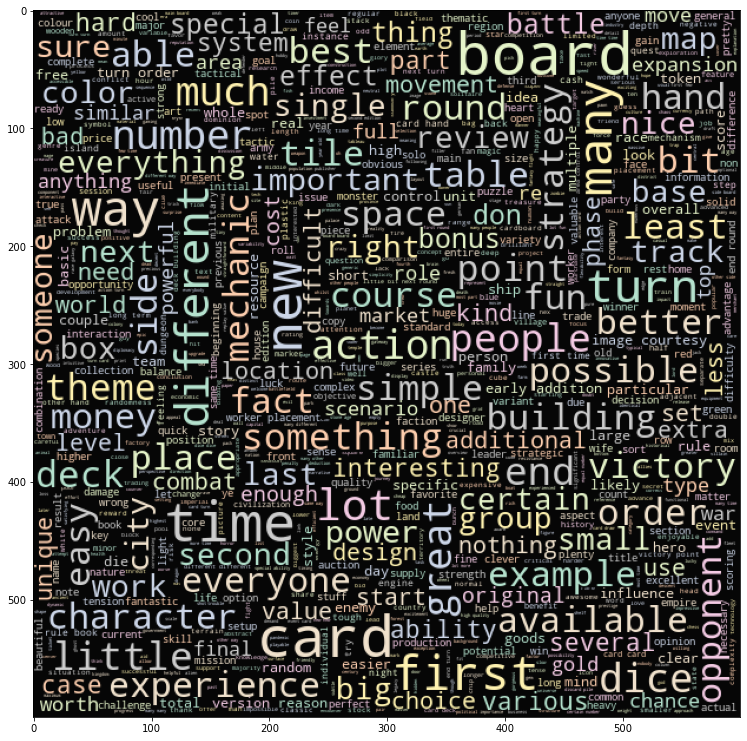

In [417]:
plt.figure(figsize=(13,13))
wc = WordCloud(background_color="black", max_words=10000,
               max_font_size= 50, width=600, height=600)
wc.generate(" ".join(noun_corpus))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)

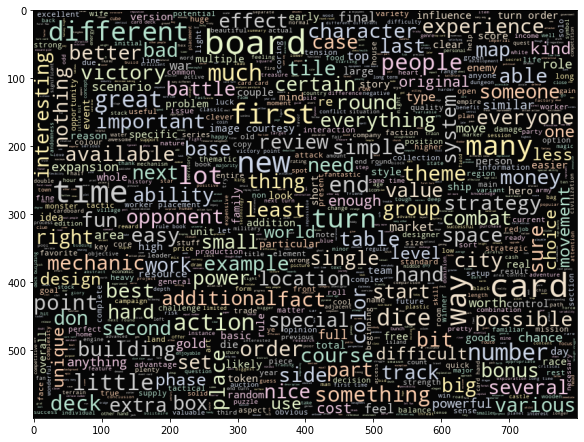

In [799]:
plt.figure(figsize=(10,7.5))
wc = WordCloud(background_color="black", max_words=1000,
               max_font_size= 50, width=800, height=600)
wc.generate(" ".join(noun_corpus))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)

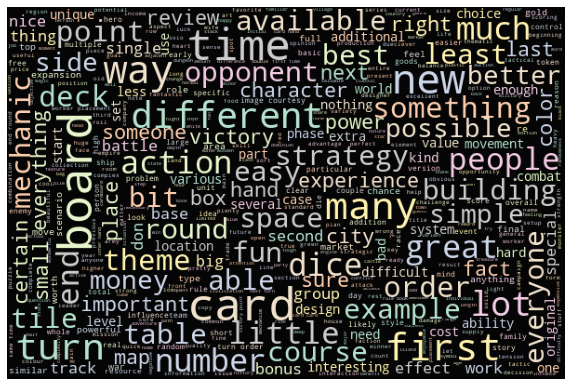

In [804]:
plt.figure(figsize=(10,7.5))
wc = WordCloud(background_color="black", max_words=1000,
               max_font_size= 50, width=600, height=400)
wc.generate(" ".join(noun_corpus))
plt.axis("off")
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)

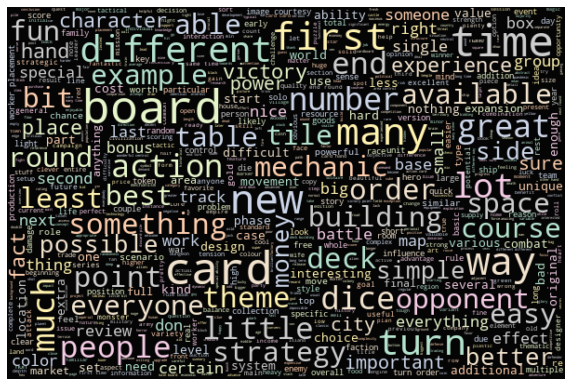

In [810]:
plt.figure(figsize=(10,7.5))
wc = WordCloud(background_color="black", max_words=1000,
               max_font_size= 50, width=600, height=400)
wc.generate(" ".join(noun_corpus))
plt.axis("off")
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98, interpolation='bilinear')


In [811]:
wc.to_file('word_cloud_n_adj_21May.png')

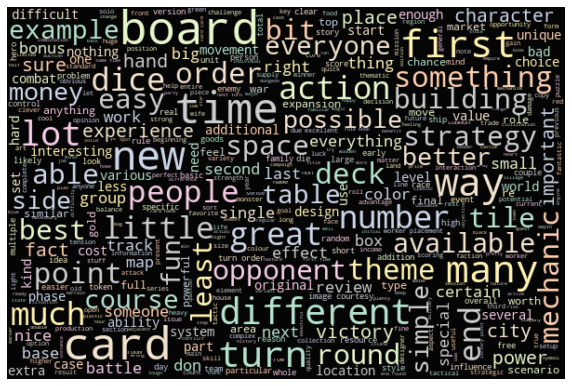

In [813]:
plt.figure(figsize=(10,7.5))
wc = WordCloud(background_color="black", max_words=400,
               max_font_size= 50, width=600, height=400)
wc.generate(" ".join(noun_corpus))
plt.axis("off")
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98, interpolation='bilinear')


### Final model

I didn't decide on a "best" model, but the model that seemed to do well in my limited testing included the following:

    Text pre-processing with:
        - keeping words in nltk word list not including ['quot', 'game', 'play', 'player', 'like', 'good']
        - keeping only nouns and adjectives
        - vectorizer=TfidfVectorizer(n_grams = (1,3)),
        - tokenizer=TreebankWordTokenizer().tokenize
    Model with:
        - NMF
        - 15 topics
        - topic array concatenated with dummified 'domains' (categories)
        